This version contains aprop_vec and the new aprop_vec_sepfunc, along with all of the separate sub-functions used in aprop_sepfunc.
Cleaned up the comments a bit in the new functions as well. 

Separating out the functions increased the speed!

In [6]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cython
import numba
import numexpr as ne

In [56]:
# simulated data to use for clustering

C1 = np.random.multivariate_normal(mean=[0,0], cov=np.eye(2), size=15)
C2 = np.random.multivariate_normal(mean=[4,4], cov=np.eye(2), size=15)
mydata = np.r_[C1, C2]

In [48]:
np.random.seed(0)
mydata = np.random.rand(4,2)
num_data_pts = mydata.shape[0]

    
    
    # matrix of all the poitwise distances as measured by the metric s
s_metric_matrix = create_s_metric_matrix(mydata)

    # same as the above except diagonal entries (IE self-preferences) are set to special values 
    # depending on num_cluster_pref
current_method = create_s_matrix(mydata, num_data_pts, num_cluster_pref=1, s_metric_matrix)
          
#current_method = create_s_matrix(mydata,mydata.shape[0] )
current_method

TypeError: create_s_matrix() got multiple values for argument 'num_cluster_pref'

In [19]:
%timeit -r3 create_s_metric_matrix(mydata)

213 µs ± 5.2 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [35]:
calc_similarity_matrix(mydata,, s_metric_matrix)

array([[-0.14761571, -0.03191478, -0.02046653, -0.04355307],
       [-0.03191478, -0.14761571, -0.04228309, -0.14761571],
       [-0.02046653, -0.04228309, -0.14761571, -0.06065054],
       [-0.04355307, -0.14761571, -0.06065054, -0.14761571]])

In [20]:
from scipy.spatial.distance import cdist
def calc_neg_euclidean(mydata):
    return - cdist(mydata, mydata, 'euclidean')** 2

In [34]:
def calc_similarity_matrix(mydata, num_cluster_pref=1):
    neg_euc_dist = - cdist(mydata, mydata, 'euclidean') ** 2
    pref = np.min(current_method) if num_cluster_pref == 1 else np.median(
        current_method)
    np.fill_diagonal(neg_euc_dist, pref)
    return neg_euc_dist

In [16]:
def s_metric(i,k, mydata): 
    
    # measure negative euclidean distance squared
    
    return -np.linalg.norm(mydata[i] - mydata[k])**2

In [13]:
def create_s_metric_matrix(mydata):
    
    # create a matrix of all pointwise distances between a list of data points
    # using s_metric function as your measure
    num_data_pts=mydata.shape[0]
    s_metric_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))
    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_metric_matrix[i,k] = s_metric(i, k, mydata)
    return s_metric_matrix

In [46]:
def s(i, k, mydata, num_cluster_pref, s_metric_matrix):
    
    # a measure for s_matrix:
    # same measure, s, as for s_metric matrix for any two distinct data points
    # for the measure of a data point with itself, 
    # use either the minimum or median s_metrix distance among all distinct point pairs,
    # depending on num_cluster_pref
    
    min_dist = np.matrix(s_metric_matrix).min()
    med_dist = np.median(s_metric_matrix)
    if i==k and num_cluster_pref==1: 
        return min_dist
    elif i==k:
        return med_dist
    else: 
        return s_metric(i, k, mydata) 

In [41]:
def create_s_matrix(mydata, num_data_pts, num_cluster_pref, s_metric_matrix):
    
    # matrix of pointwise distances, this time using s instead of s_metric
    
    s_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts))
    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_matrix[i,k] = s(i, k, mydata, num_cluster_pref, s_metric_matrix)
    return s_matrix

In [61]:
def init_r_array(num_data_pts, s_matrix):
    
    # compute r(i,k) values for iteration 0
    
    max_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts)) 
    for i in range(num_data_pts): 
        for k in range(num_data_pts): 
            s_matrix_mask = np.ma.array(s_matrix, mask=False)
            s_matrix_mask.mask[i,k] = True 
            max_matrix[i,k] = np.max(s_matrix_mask[i,:]) 
    r_array_0 = s_matrix - max_matrix
    return r_array_0

In [62]:
def a_array_update(num_data_pts, niter, r_array, damp_c, a_array):
    
    # update a(i,k) values for iteration #niter
    
    for i in range(num_data_pts):
        for k in range(num_data_pts):
                if i != k:
                    temp_vec = np.ones(num_data_pts)
                    temp_vec[k] = 0
                    temp_vec[i] = 0
                    temp_vec[r_array[niter-1, :, k]<0] = 0
                    a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) 
                    for_min = np.concatenate((r_array[niter-1,k,k] + a_ik_sum, np.zeros(1)), axis=None)
                    update_term = np.min(for_min)
                    a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
                else:
                    temp_vec = np.ones(num_data_pts)
                    temp_vec[k] = 0
                    temp_vec[r_array[niter-1, :, k]<0] = 0
                    a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) 
                    update_term = a_ik_sum
                    a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
    return a_array[niter]

In [63]:
def r_array_update(num_data_pts, niter, a_array, s_matrix, damp_c, r_array):

    # update a(i,k) values for iteration #niter
    
    for i in range(num_data_pts):
        for k in range(num_data_pts):
            s_a_array_sum = a_array[niter] + s_matrix
            s_a_array_sum_mask = np.ma.array(s_a_array_sum, mask=False)
            s_a_array_sum_mask.mask[:,k] = True
            s_a_array_sum_max = np.max(s_a_array_sum_mask[i,:])
            update_term = s_matrix[i,k] - s_a_array_sum_max
            r_array[niter,i,k] = damp_c * update_term + (1-damp_c) * r_array[niter-1,i,k]
    return r_array[niter]

In [64]:
# function definition - not vectorized

def aprop_vec_sepfunc(mydata, num_cluster_pref=1, iterations=100, damp_c=0.5, num_stable_iters=10):
    
    # data input error messages
    if mydata.shape[1] != 2:
        raise ValueError("S must have two columns.")
    if num_cluster_pref != 1 and num_cluster_pref != 2:
        raise ValueError("Enter valid indication (1 or 2) of cluster number preference.")
    if iterations <1 or type(iterations) != int:
        raise ValueError("Enter a valid number of iterations.")
    if damp_c <= 0 or damp_c > 1:
        raise ValueError("Enter a valid damping constant.")
    if num_stable_iters < 1 or num_stable_iters > iterations or type(num_stable_iters) != int:
        raise ValueError("Enter a valid number of iterations to check for stability.")
    
    # count number of data points, IE number rows in mydata
    num_data_pts = mydata.shape[0]

    # matrix of all the poitwise distances as measured by the metric s
    s_metric_matrix = create_s_metric_matrix(mydata, num_data_pts)

    # same as the above except diagonal entries (IE self-preferences) are set to special values 
    # depending on num_cluster_pref
    s_matrix = create_s_matrix(mydata, num_data_pts, num_cluster_pref, s_metric_matrix)
            
    # initialize a_array: a(i,k) = 0 at 0th iteration
    a_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # initialize r_array 
    r_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # fill in r_array values for 0th iteration
    r_array[0] = init_r_array(num_data_pts, s_matrix)
    
    ### iterative loop for iterations 1+ 

    # define tracker variables for checking for stability
    clusters_prev = np.zeros(num_data_pts)
    clusters_prev_2 = np.zeros(num_data_pts)
    iter_stability = np.zeros(iterations)

    
    for niter in range(1,iterations):

        # update a and r arrays at each iteration
        a_array[niter] = a_array_update(num_data_pts, niter, r_array, damp_c, a_array)
        r_array[niter] = r_array_update(num_data_pts, niter, a_array, s_matrix, damp_c, r_array)
                
        r_s_sum_array = r_array[niter] + a_array[niter]

        # results of each iteration's clustering attempt
        clusters = np.argmax(r_s_sum_array, axis=1) # the list points grouped by their assigned center
        centers = np.where(np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts))) # the points that are centers
        is_center = np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts)) # true if pt is a center, false otherwise
        
        # record whether this iteration's clustering is the same as in previous iteration
        if np.array_equal(clusters, clusters_prev): 
            iter_stability[niter] = 1 
        
        # if you have seen enough identical clusterings in a row,
        # create a scatterplot illustrating the results 
        # and break the iteration loop and return the final clustering results
        if niter>num_stable_iters and np.all(iter_stability[niter-num_stable_iters:niter]==1): 
            plt.scatter(mydata[:,0], mydata[:,1], c=np.argmax(r_s_sum_array, axis=1), s = 200)
            plt.scatter(mydata[:,0][is_center], mydata[:,1][is_center], marker='+', s=350, c='black')
            cluster_plot = plt.show()
            exemplars=centers[0]
            num_clusters = len(np.unique(clusters))
            final_iter = niter+1
            return clusters, exemplars, cluster_plot, num_clusters, final_iter
            break 
            
        # if you have not seen enough identical clusterings in a row by the final iteration,
        # just print a message
        elif niter == iterations-1:
            print("Stability not acheived. Consider reducing num_stable_iters.")
            
        # track the previous cluster, for checking stability in next iteration
        clusters_prev = clusters



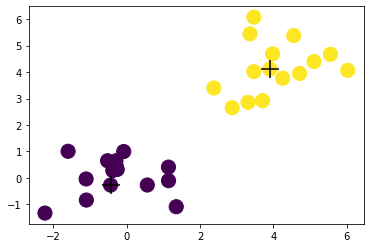

CPU times: user 3.39 s, sys: 192 ms, total: 3.58 s
Wall time: 3.34 s


(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]),
 array([13, 22]),
 None,
 2,
 26)

In [65]:
%%time

aprop_vec_sepfunc(mydata)

In [66]:
# function definition - vectorized

def aprop_vec(mydata, num_cluster_pref=1, iterations=100, damp_c=0.5, num_stable_iters=10):
    
    """
    Perform clustering by affinity propagation. 
    
    
    Parameters
    ----------
    
    mydata : array-like, shape (num_data_pts, 2)
        Data set for clustering.
        
    num_cluster_pref : int (1 or 2), optional, default: 1
        Indication of whether the input similarities are set to the minimum similarity measure 
        (IE, negative squared Euclidean distance) between the data points (num_cluster_pref = 1), 
        or the median similarity measure (num_cluster_pref = 2).
        
    iterations : int, optional, default: 100
        Maximum number of iterations to run affinity propagation.
    
    damp_c : float, optional, default: 0.5
        Damping constant. The weight given to the updating iteration; between 0 and 1.
        
    num_stable_iters : int, optional, default: 10
        The algorithm stops if the clusterings at each iteration have remained unchanged for 
        this many iterations in a row.
        
       
    Returns
    -------
    
    clusters : array, shape (num_data_pts, 1)
        For the index of each data point, gives that data point's exemplar.
    
    exemplars : array, shape(num_exemplars, 1)
        List the indices of the data points that are exemplars.
    
    cluster_plot : figure
        Scatter plot of the data, with points in the same cluster hacing the same color, and
        exemplars marked with plus-signs.
        
    num_clusters : int
        Number of clusters in final clustering.
        
    final_iter : int
        Number of iterations that were run before the algorithm stopped.
        
        
    Notes
    -----
    
    Input preferences should be set to the minimum similarity measure when a small number of clusters
    is preferred, and to the median similarity measure when a moderate number of clusters is 
    preferred.
    
    If stability is not acheived, the aglorithm does not output the returned objects but 
    rather prints an error message: "Stability not acheived. Consider reducing num_stable_iters."
    
    
    References
    ----------
    
    Brendan J. Frey and Delbert Dueck, "Clustering by Passing Messages
    Between Data Points", Science Feb. 2007
    
    """
    
    # data input error messages
    if mydata.shape[1] != 2:
        raise ValueError("S must have two columns.")
    if num_cluster_pref != 1 and num_cluster_pref != 2:
        raise ValueError("Enter valid indication (1 or 2) of cluster number preference.")
    if iterations <1 or type(iterations) != int:
        raise ValueError("Enter a valid number of iterations.")
    if damp_c <= 0 or damp_c > 1:
        raise ValueError("Enter a valid damping constant.")
    if num_stable_iters < 1 or num_stable_iters > iterations or type(num_stable_iters) != int:
        raise ValueError("Enter a valid number of iterations to check for stability.")
    
    # count number of data points, IE number rows in mydata
    num_data_pts = mydata.shape[0]
    
    s_metric_matrix = create_s_metric_matrix(mydata, num_data_pts)

    s_matrix = create_s_matrix(mydata, num_data_pts, num_cluster_pref, s_metric_matrix)
            
            
    # a(i,k) = 0 at first iteration
    a_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # initialize r_array 
    r_array = np.zeros(num_data_pts * num_data_pts * (iterations)).reshape((iterations, num_data_pts, num_data_pts))

    # fill in r_array values for 0th iteration 
    ## edit
    max_matrix = np.zeros(num_data_pts * num_data_pts).reshape((num_data_pts, num_data_pts)) # initialize
    for i in range(num_data_pts): # for each row i
        for k in range(num_data_pts): # for each col k
            # mask the (i,k)th element in similarity matrix
            s_matrix_mask = np.ma.array(s_matrix, mask=False)
            s_matrix_mask.mask[i,k] = True # mask item (i,k)
            max_matrix[i,k] = np.max(s_matrix_mask[i,:]) # get max in row i, but without item (i,k)

    r_array[0] = s_matrix - max_matrix
    
    ### iterative loop for iterations 1+ 

    clusters_prev = np.zeros(num_data_pts)
    iter_stability = np.zeros(iterations)

    for niter in range(1,iterations):

        # a_array update
        for i in range(num_data_pts):
            for k in range(num_data_pts):
                    if i != k:
                        ### BEGIN: code edited for vectorization
                        # temp_vec is a vector of ones for each data point, except zeros for the ones that ashould be masked
                        temp_vec = np.ones(num_data_pts)
                        temp_vec[k] = 0
                        temp_vec[i] = 0
                        temp_vec[r_array[niter-1, :, k]<0] = 0
                        a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) # do the summation using a dot product, instead of the masking process used previously for computing each individual entry
                        ### END: code edited for vectorization
                        for_min = np.concatenate((r_array[niter-1,k,k] + a_ik_sum, np.zeros(1)), axis=None)
                        update_term = np.min(for_min)
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
                    else:
                        ### BEGIN: code edited for vectorization
                        temp_vec = np.ones(num_data_pts)
                        temp_vec[k] = 0
                        temp_vec[r_array[niter-1, :, k]<0] = 0
                        a_ik_sum = np.dot(r_array[niter-1, :, k], temp_vec) # do the summation using a dot product, instead of the masking process used previously for computing each individual entry
                        ### END: code edited for vectorization
                        update_term = a_ik_sum
                        a_array[niter,i,k] = damp_c * update_term + (1-damp_c) * a_array[niter-1,i,k]
                        
        # r_array update
        for i in range(num_data_pts):
            for k in range(num_data_pts):
                s_a_array_sum = a_array[niter] + s_matrix
                temp_vec = np.ones(num_data_pts)
                temp_vec[k] = 0
                s_a_array_sum_max = np.max(np.dot(s_a_array_sum[i,:], temp_vec))
                s_a_array_sum_mask = np.ma.array(s_a_array_sum, mask=False)
                s_a_array_sum_mask.mask[:,k] = True
                s_a_array_sum_max = np.max(s_a_array_sum_mask[i,:])
                update_term = s_matrix[i,k] - s_a_array_sum_max
                r_array[niter,i,k] = damp_c * update_term + (1-damp_c) * r_array[niter-1,i,k]
        r_s_sum_array = r_array[niter] + a_array[niter]

        # print illustration of first clustering that remains stable over two iterations
        # centers marked by black plus signs
        # points assigned to same center have same color
        if niter > 0: 
            clusters = np.argmax(r_s_sum_array, axis=1) # the list points grouped by their assigned center
            centers = np.where(np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts))) # the points that are centers
            is_center = np.argmax(r_s_sum_array, axis=1) == np.array(range(num_data_pts)) # true if pt is a center, false otherwise
            if np.array_equal(clusters, clusters_prev): # if the clustering in this iteration is the same as the previous one
                iter_stability[niter] = 1 
            if niter>num_stable_iters and np.all(iter_stability[niter-num_stable_iters:niter]==1): # if you have seen enough of the same clusterings in a row
                plt.scatter(mydata[:,0], mydata[:,1], c=np.argmax(r_s_sum_array, axis=1), s = 200)
                plt.scatter(mydata[:,0][is_center], mydata[:,1][is_center], marker='+', s=350, c='black')
                cluster_plot = plt.show()
                exemplars=centers[0]
                num_clusters = len(np.unique(clusters))
                final_iter = niter+1
                return clusters, exemplars, cluster_plot, num_clusters, final_iter
                break 
            elif niter == iterations-1:
                print("Stability not acheived. Consider reducing num_stable_iters.")
            clusters_prev = clusters



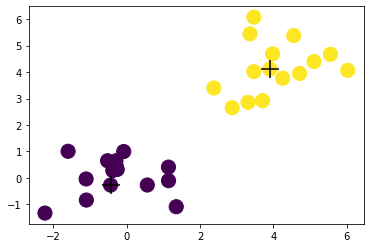

CPU times: user 4.08 s, sys: 216 ms, total: 4.3 s
Wall time: 4.03 s


(array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]),
 array([13, 22]),
 None,
 2,
 26)

In [67]:
%%time

# check time for vectorized code
aprop_vec(mydata=mydata)